## Packages

In [1]:
# to speed-up execution, mark this as True
USE_CACHED_RESULTS=False
# cross-fold crashes Github CI
USE_CACHED_CV5_RESULTS = True

In [2]:
import maxent
import maxentep as py0
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyabc
import os
import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sns.set_context('paper')

## Set-up SEAIR Model

In [3]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)

[4241. 3868. 1023.] [144101. 110004. 124468.]


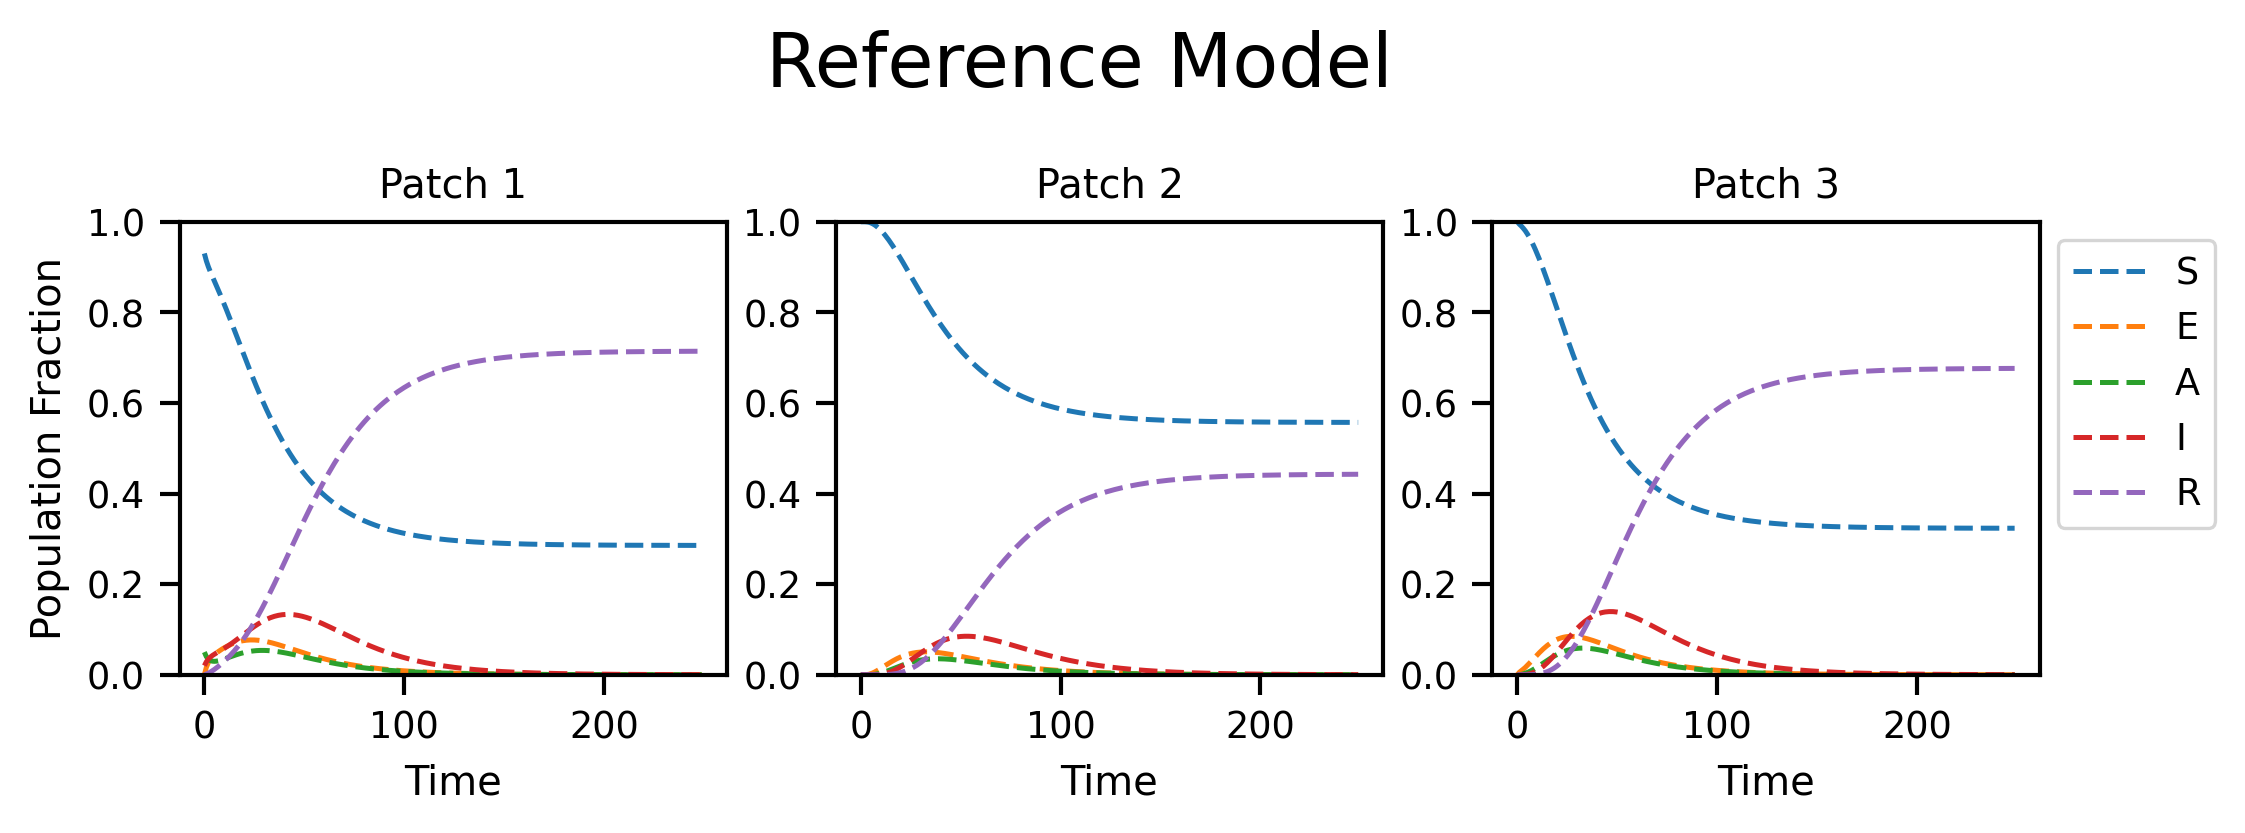

In [8]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
infect_fxn = py0.contact_infection_func(infections_compartments)
full_compartments = ['S'] + compartments
R = np.array([[1000, 400, 10],
         [0, 300, 300],
         [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
def metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time):
    beta = 0.025
    start = np.zeros((3,4))
    start[0,2] = start_infected
    start[0,1] = start_asymptomatic
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', E_time, 0)
    tmat.add_transition('A', 'I', A_time, 0)
    tmat.add_transition('I', 'R', I_time, 0)
    timesteps = 250
    meta_model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    return trajectory
ref_inpputs = [0.02, 0.05, 7, 5, 14]
ref_traj = metapop_wraper(*ref_inpputs )
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--', label=full_compartments)
axs[0].set_ylabel('Population Fraction')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [9]:
npoints = 5
np.random.seed(0)
prior = maxent.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300826 0.10784731813725082
45 0.13207552 0.1526054434665933
31 0.12169184 0.12889401646488136
80 0.06942835 0.1421420223992924
17 0.08018874 0.11824062257689161


## Sample SEAIR Trajectories

In [10]:
tf.random.set_seed(0)
if not USE_CACHED_RESULTS or not os.path.exists('epidemiology_files/maxent_sample_trajs'):
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 1)
    tmat.add_transition('A', 'I', 2, 4)
    tmat.add_transition('I', 'R', 10, 5)
    start_logits = np.zeros((M))
    hyper_pram = py0.ParameterHypers()
    hyper_pram.beta_var = 0.9
    hyper_pram.beta_start = 0.01
    hyper_pram.beta_high = 0.15
    hyper_pram.beta_low = 0.001
    hyper_pram.start_mean = 0.001
    hyper_pram.start_high = 0.4
    hyper_pram.start_var = 0.8
    param_model = py0.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)
    # Fxing beta and mobility matrix
    R_norm_sample = tf.convert_to_tensor(R_norm)
    beta_sample = tf.convert_to_tensor([0.025])
    N = 2048
    batches = 4
    batch_size = N*batches
    outs = []
    timesteps = 250
    model = py0.MetaModel(infect_fxn, timesteps, populations=population_fraction)
    for b in tqdm.tqdm(range(batches)):
        psample = param_model.sample(N)
        psample[0] = tf.repeat(R_norm_sample[tf.newaxis,:], len(psample[0]), axis =0) 
        psample[3] = tf.repeat(beta_sample[tf.newaxis,:], len(psample[0]), axis =0)
        outs.append(model(*psample))
    trajs = np.concatenate(outs, axis=0)
    np.save('epidemiology_files/maxent_sample_trajs', trajs)
else:
    trajs = np.load('epidemiology_files/maxent_sample_trajs.npy')


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.29s/it]


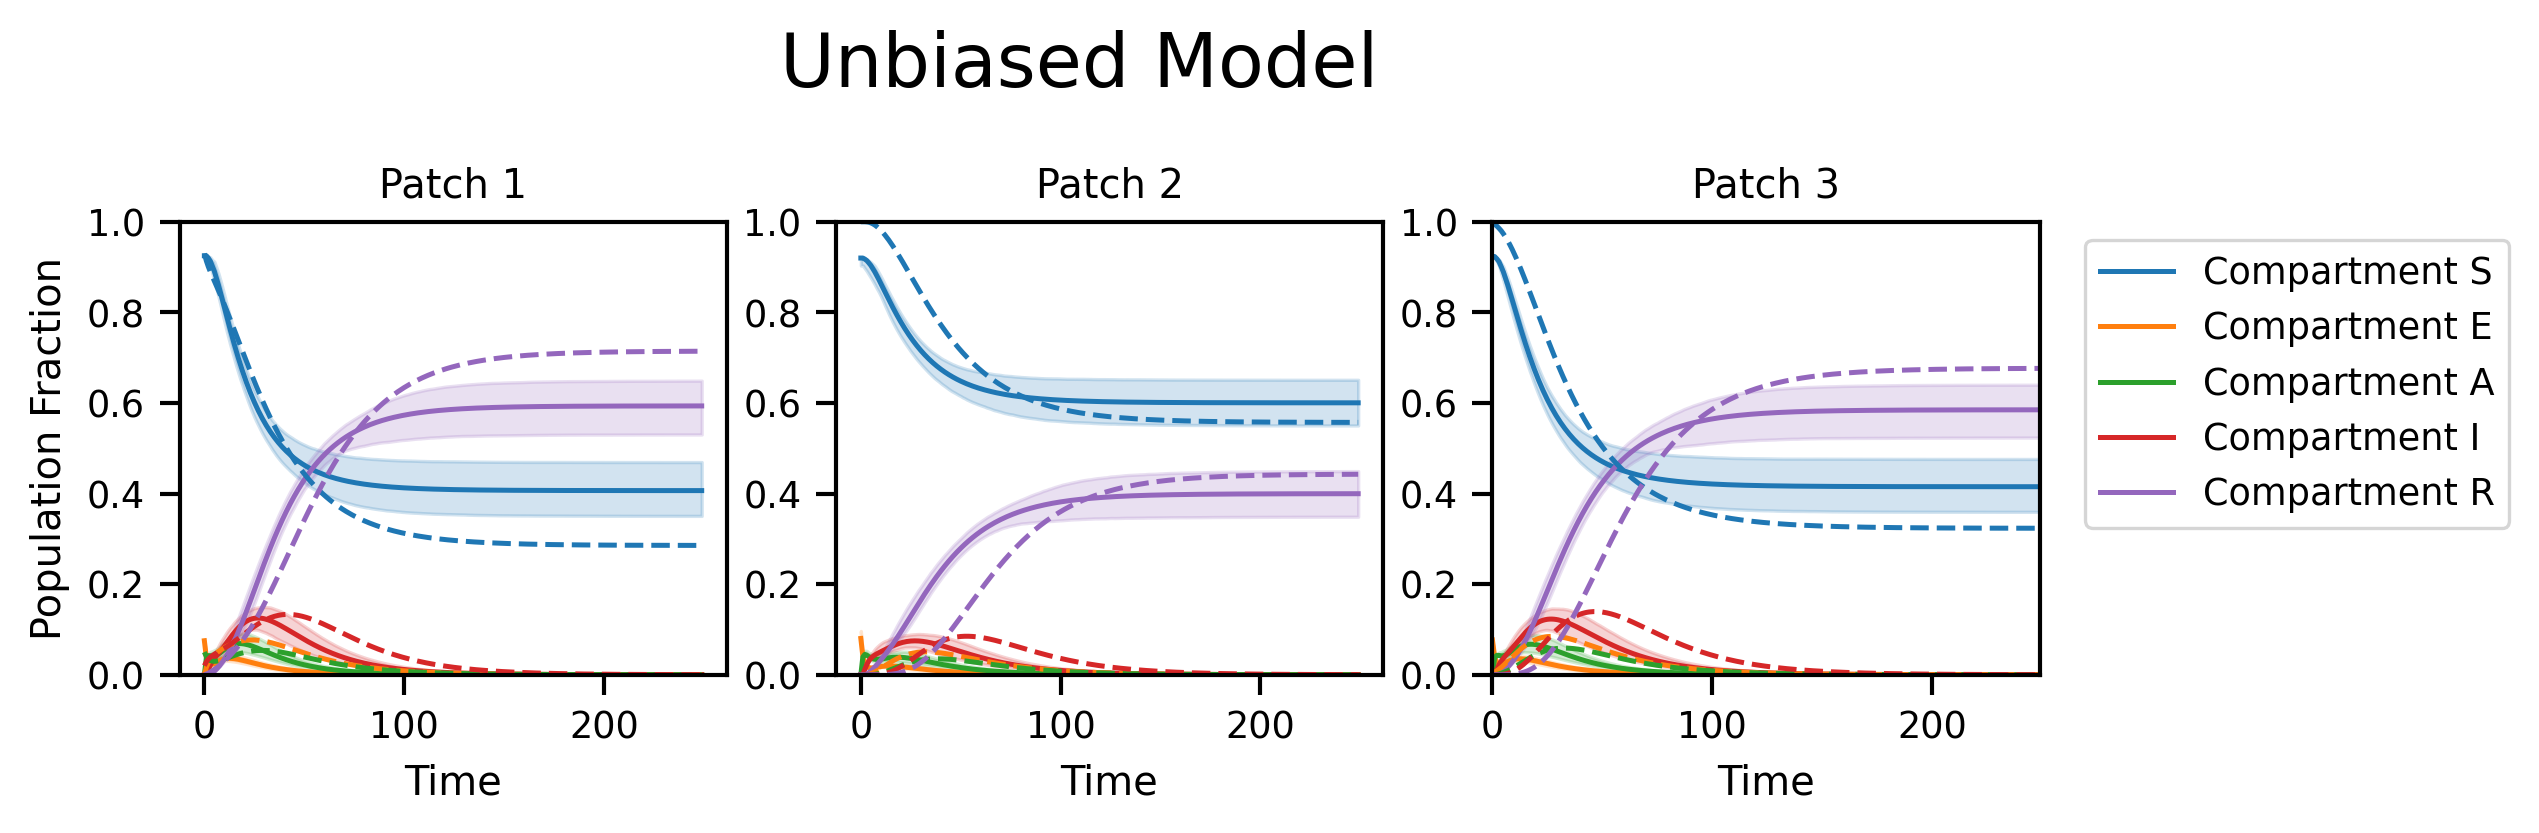

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

In [8]:
if not USE_CACHED_RESULTS:
    me_model = maxent.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000)
    me_w = me_model.traj_weights
    np.save('epidemiology_files/maxent_biased_me_w', me_w)
else:
    me_w = np.load('epidemiology_files/maxent_biased_me_w.npy')

Epoch 1/1000
1/1 [==============================] - 1s 558ms/step - loss: 0.0042 - weight-entropy: 9.0092
Epoch 2/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0041 - weight-entropy: 9.0100
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 9.0104
Epoch 4/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0039 - weight-entropy: 9.0104
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0038 - weight-entropy: 9.0099
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 9.0089
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 9.0074
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0036 - weight-entropy: 9.0054
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 9.0030
Epoch 10/1000
1/1 [==============================] - 0s 2ms/st

1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4931
Epoch 80/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4901
Epoch 81/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4873
Epoch 82/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 8.4845
Epoch 83/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4819
Epoch 84/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4794
Epoch 85/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4770
Epoch 86/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 8.4747
Epoch 87/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 8.4726
Epoch 88/1000
1/1 [==============================] - 0s 1ms/step - lo

1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 8.3406
Epoch 234/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 8.3398
Epoch 235/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.3391
Epoch 236/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.3384
Epoch 237/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.3377
Epoch 238/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 8.3369
Epoch 239/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.3362
Epoch 240/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.3355
Epoch 241/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 8.3348
Epoch 242/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.2429
Epoch 388/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.2424
Epoch 389/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.2418
Epoch 390/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.2412
Epoch 391/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.2407
Epoch 392/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 8.2401
Epoch 393/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.2396
Epoch 394/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.2391
Epoch 395/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 8.2385
Epoch 396/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1641
Epoch 542/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1636
Epoch 543/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1631
Epoch 544/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1626
Epoch 545/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1620
Epoch 546/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1615
Epoch 547/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1610
Epoch 548/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1605
Epoch 549/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 8.1600
Epoch 550/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 8.0728
Epoch 696/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 8.0721
Epoch 697/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 8.0713
Epoch 698/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 8.0706
Epoch 699/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 8.0698
Epoch 700/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 8.0691
Epoch 701/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 8.0683
Epoch 702/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 8.0675
Epoch 703/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 8.0668
Epoch 704/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.9184
Epoch 850/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.9171
Epoch 851/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.9158
Epoch 852/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.9146
Epoch 853/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.9133
Epoch 854/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.9120
Epoch 855/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.9107
Epoch 856/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.9093
Epoch 857/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 7.9080
Epoch 858/1000
1/1 [==============================] - 0s 2ms/

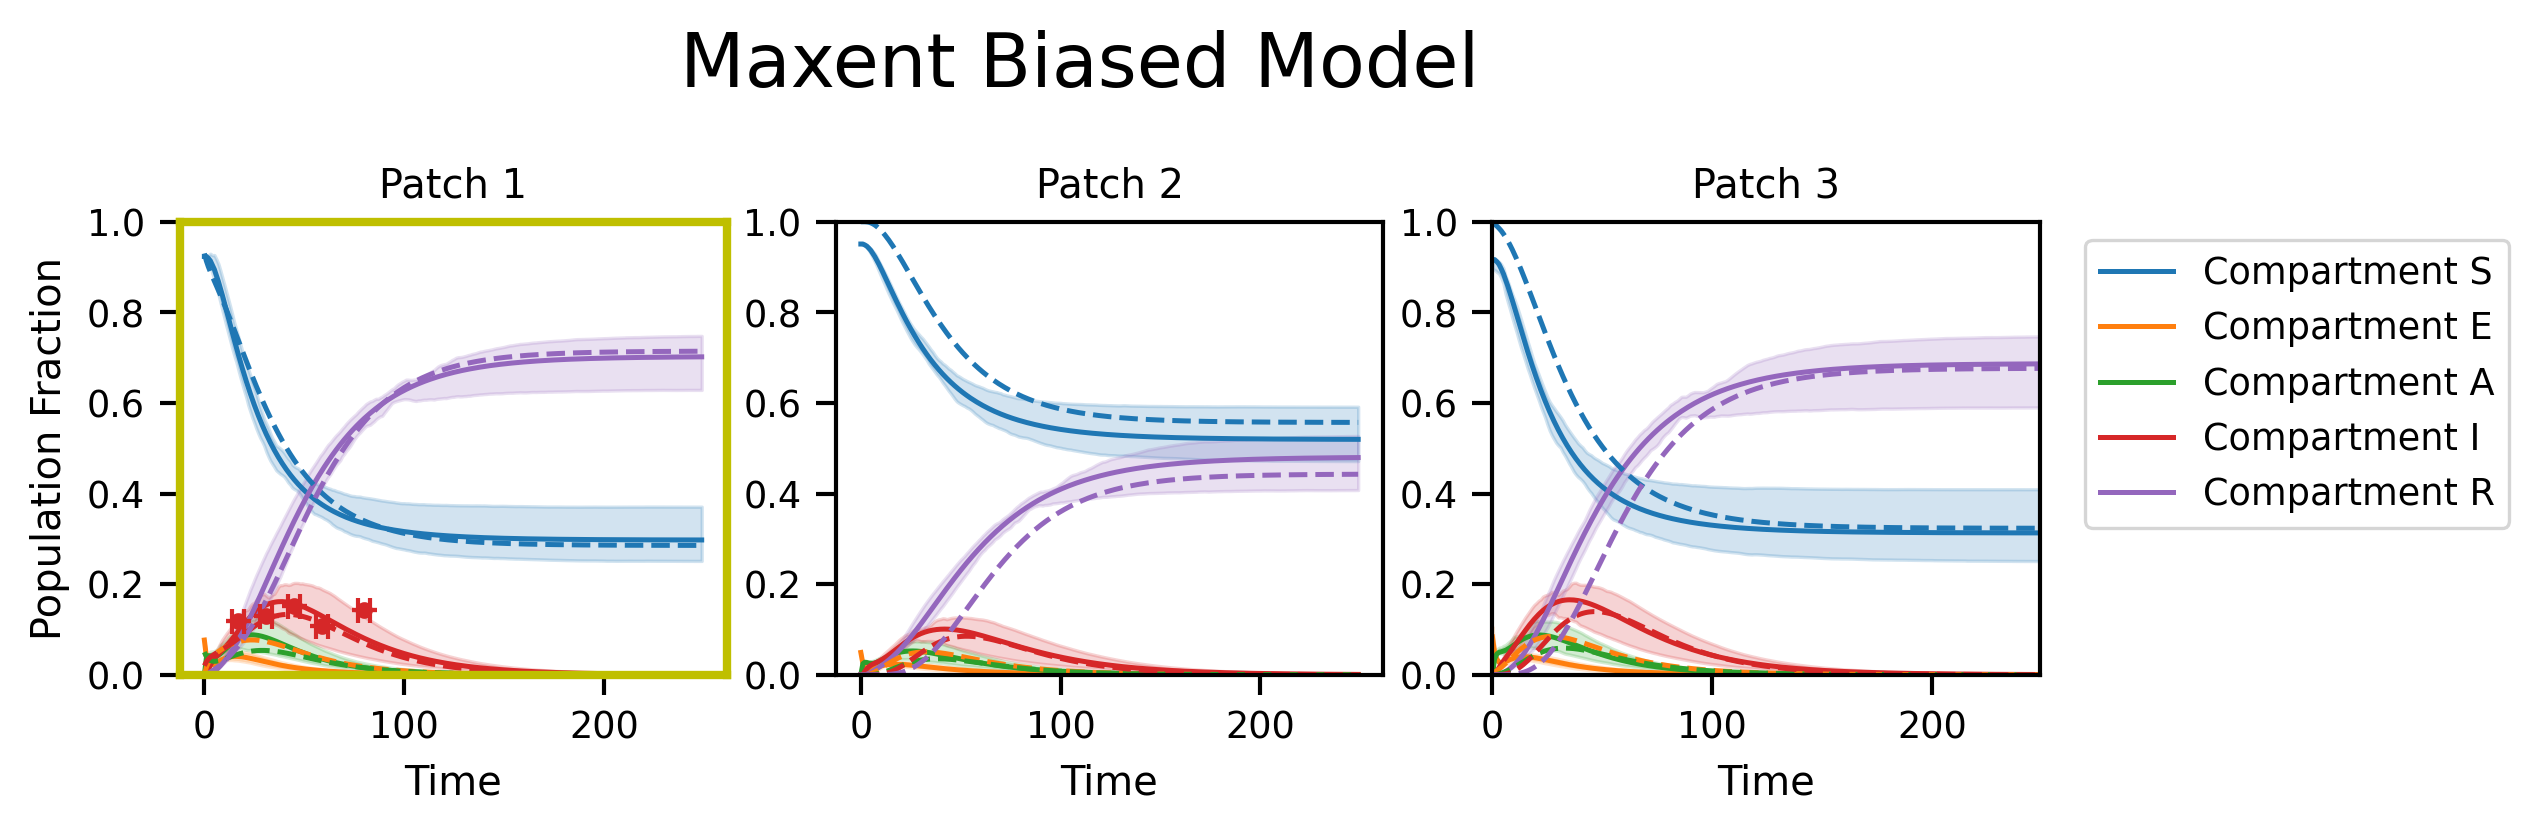

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Maxent Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(trajs[:,:,0,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,1,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(trajs[:,:,2,:], weights=me_w, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [10]:
if not USE_CACHED_RESULTS:
    C = len(compartments)
    start = np.zeros((M, C))
    start[0,1] = 0.001
    start[0,2] = 0.001
    beta_start = 0.1
    infect = py0.ContactInfectionLayer(beta_start, infections_compartments)
    # make "agreement" function
    def agreement(traj, rs=restraints):
        s = 0
        for r in rs:
            s += r(traj[0])**2
        return s
    rmodel = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, agreement)
    rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
    utraj = rmodel.get_traj()
    rmodel.fit(timesteps)
    regressed_traj = rmodel.get_traj()
    np.save('epidemiology_files/ls_biased_traj', regressed_traj)
else:
    regressed_traj = np.load('epidemiology_files/ls_biased_traj.npy')

250/250 [==============================] - 10s 36ms/step - loss: 0.0055 - output_2_loss: 0.0055


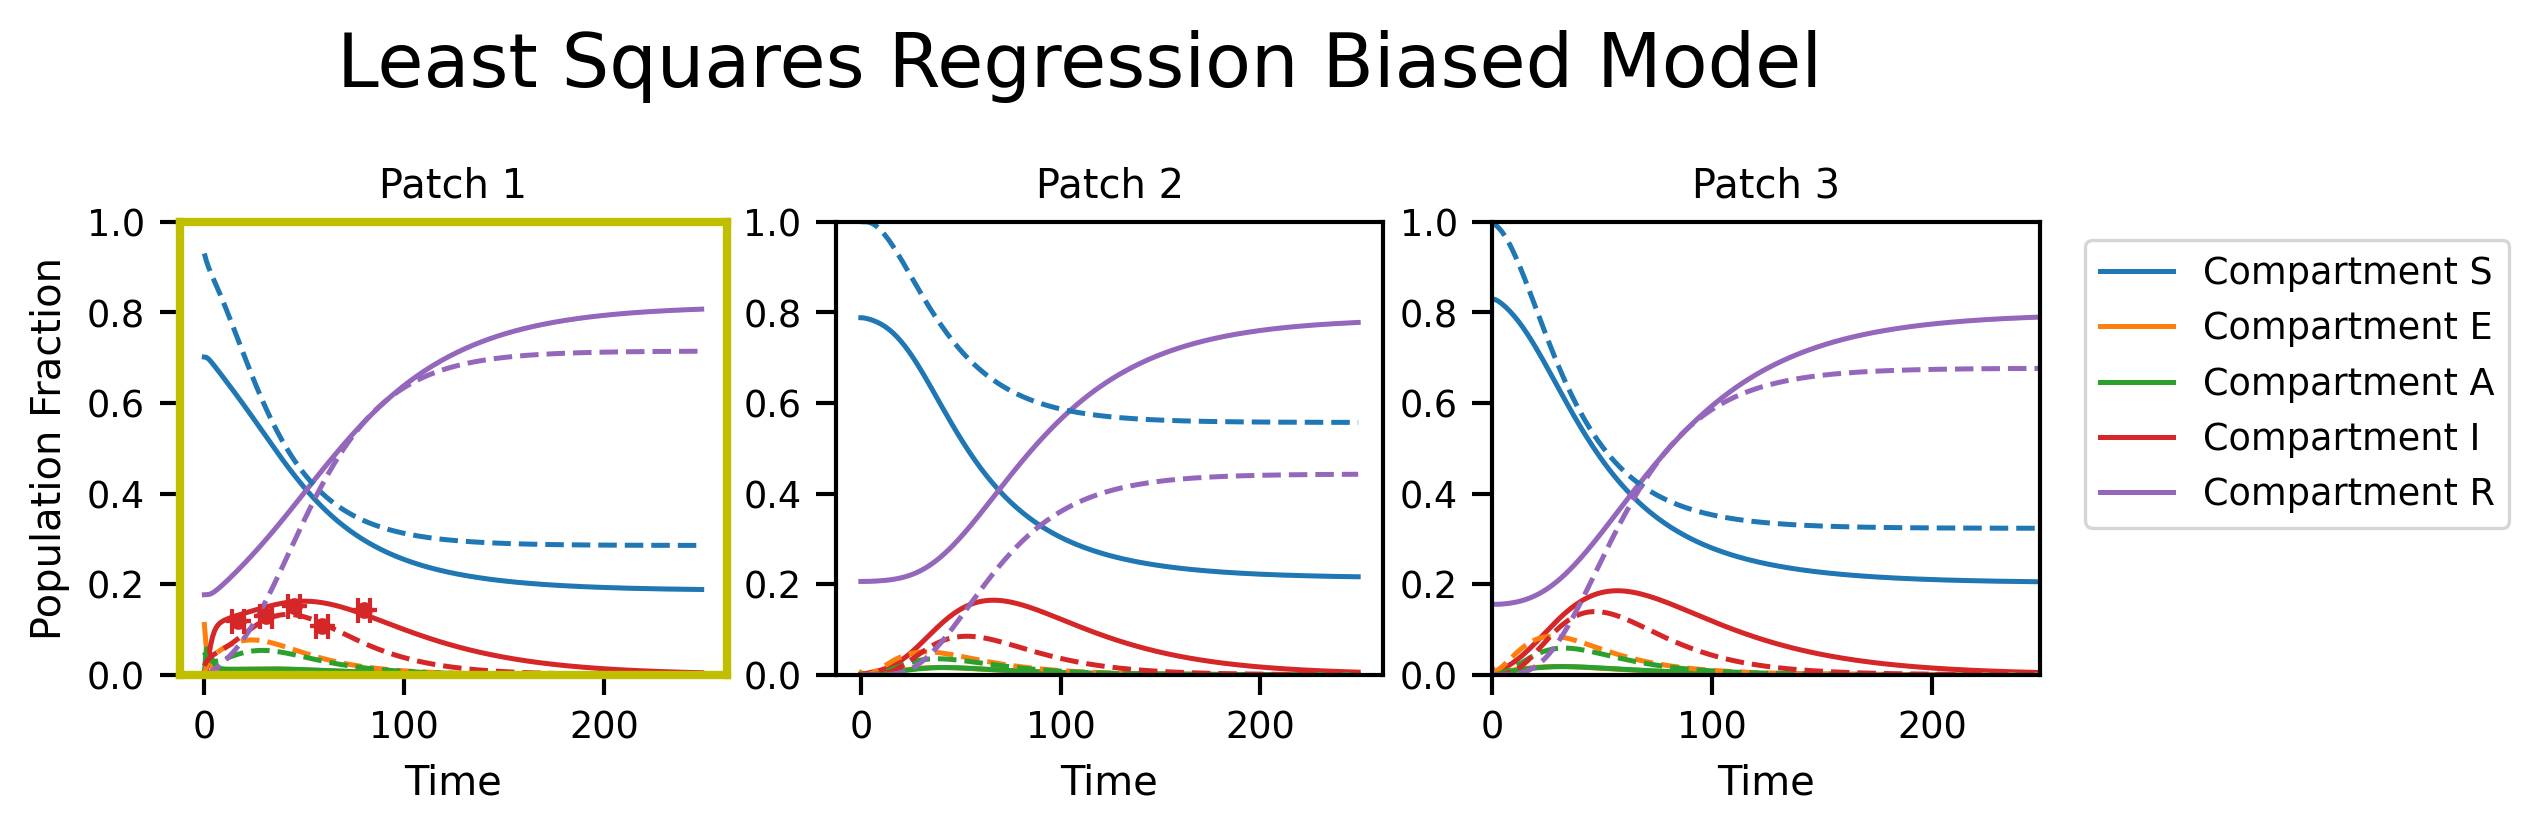

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regression Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## abc

In [16]:
np.random.seed(0)
start_infected = 0.001
start_asymptomatic = 0.001
E_time = 2
A_time = 2
I_time = 10
abc_param_keys = ['start_infected', 'start_asymptomatic', 'E_time', 'A_time', 'I_time']
abc_param_values = [ start_infected, start_asymptomatic, E_time, A_time, I_time ] 
abc_parameters = dict(zip(abc_param_keys, abc_param_values))

def abc_model(parameter):
    trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']), \
                               + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time'])  )
    restrainted_time_values = [59, 45, 31, 80, 17]
    values = np.array([trajectory[m,0,3].numpy() for m in restrainted_time_values])
    return {'data': values}

def distance(x, y):
    d = np.sum(np.abs(x['data'] - y['data']))
    return(d)
if not USE_CACHED_RESULTS:
    parameter_priors = pyabc.Distribution(
                                    start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                    start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                    E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                    A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                    I_time=pyabc.RV('norm', abc_param_values[4], 5))

    abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
    db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db') 
    observation = np.array([r.target for r in restraints])
    abc.new(db_path, {'data': observation})
    history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
    df, w_abc = history.get_distribution(m=0, t=history.max_t)
    abc_trajs=np.empty((len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
    for i, row in enumerate(tqdm.tqdm(np.array(df))):
        A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc= row[0], row[1], row[2], row[3], row[4]
        traj = metapop_wraper(start_infected_abc, start_asymptomatic_abc, E_time_abc,A_time_abc, I_time_abc)
        abc_trajs[i] = traj
    abc_biased_traj = np.sum(abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis = 0)
    np.save('epidemiology_files/abc_biased_traj.npy', abc_biased_traj)
else:
    abc_biased_traj = np.load('epidemiology_files/abc_biased_traj.npy')

INFO:Sampler:Parallelizing the sampling on 16 cores.
INFO:History:Start <ABCSMC(id=4, start_time=2021-08-03 20:28:08.998960, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.4947641586901674
INFO:ABC:t: 0, eps: 0.4947641586901674.
INFO:ABC:Acceptance rate: 100 / 219 = 4.5662e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.38435913315826437.
INFO:ABC:Acceptance rate: 100 / 239 = 4.1841e-01, ESS=6.2138e+01.
INFO:ABC:t: 2, eps: 0.3287198206807549.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01, ESS=5.5395e+01.
INFO:ABC:t: 3, eps: 0.2875645439526921.
INFO:ABC:Acceptance rate: 100 / 240 = 4.1667e-01, ESS=5.6249e+01.
INFO:ABC:t: 4, eps: 0.24658838319088924.
INFO:ABC:Acceptance rate: 100 / 212 = 4.7170e-01, ESS=4.2200e+01.
INFO:History:Done <ABCSMC(id=4, start_time=2021-08-03 20:28:08.998960, end_time=2021-08-03 20:28:56.873078)>
100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


## 5-fold cross validation

In [ ]:
if not USE_CACHED_CV5_RESULTS:
    LS_traj_folds = np.empty((npoints,trajs.shape[1],trajs.shape[2],trajs.shape[-1]))
    MaxEnt_traj_folds = np.empty_like(LS_traj_folds)
    abc_traj_folds = []
    for i in range(npoints):
        sampled_restraints = [n for n in restraints if n != restraints[i]]
        ## MaxEnt
        print(f'Initializing LS for fold {i}')
        def new_agreement(traj, rs=sampled_restraints):
            s = 0
            for r in rs:
                s += r(traj[0])**2
            return s
        rmodel_sampled = py0.TrainableMetaModel(start, R_norm, tmat.value, infect, timesteps, new_agreement)
        rmodel_sampled.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
        utraj_sampled = rmodel_sampled.get_traj()
        rmodel_sampled.fit(timesteps)
        regressed_traj_sampled = rmodel_sampled.get_traj()
        LS_traj_folds[i,:,:,:] = regressed_traj_sampled
        ## MaxEnt
        print(f'Initializing MaxEnt for fold {i}')
        me_model_sample = py0.MaxentModel(sampled_restraints, trajs=trajs, population_fraction=population_fraction)
        me_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
        me_history_sample = me_model_sample.fit(trajs, batch_size=batch_size, epochs=1000)
        MaxEnt_traj_folds[i,:,:,:] = np.sum(me_model_sample.trajs * me_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        ## ABC
        print(f'Initializing ABC for fold {i}')
        def abc_model(parameter):
            trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']),
                                        + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time']))
            restrainted_time_values = [59, 45, 31, 80, 17]
            restrainted_time_values.pop(i)
            values = np.array([trajectory[m, 0, 3].numpy()
                               for m in restrainted_time_values])
            return {'data': values}
        parameter_priors = pyabc.Distribution(
                                        start_infected=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[0], 0.8),
                                        start_asymptomatic=pyabc.RV('truncnorm', 0, 0.5, abc_param_values[1], 0.8),
                                        E_time=pyabc.RV('norm', abc_param_values[2], 1),
                                        A_time=pyabc.RV('norm', abc_param_values[3], 4),
                                        I_time=pyabc.RV('norm', abc_param_values[4], 5))

        abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
        db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR.db')
        observation_abc = np.array([r.target for r in sampled_restraints])
        abc.new(db_path, {'data': observation_abc})
        history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
        df, w_abc = history.get_distribution(m=0, t=history.max_t)
        abc_trajs = np.empty(
            (len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
        for j, row in enumerate(tqdm.tqdm(np.array(df))):
            A_time_abc, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc = row[
                0], row[1], row[2], row[3], row[4]
            traj = metapop_wraper(
                abs(start_infected_abc), abs(start_asymptomatic_abc), E_time_abc, A_time_abc, I_time_abc)
            abc_trajs[j] = traj
        mean_abc_traj = np.sum(
                abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
        abc_traj_folds.append(mean_abc_traj)
    np.save('epidemiology_files/abc_traj_folds.npy', abc_traj_folds)
    np.save('epidemiology_files/MaxEnt_traj_folds.npy', MaxEnt_traj_folds)
    np.save('epidemiology_files/LS_traj_folds.npy', LS_traj_folds)
abc_traj_folds = np.load('epidemiology_files/abc_traj_folds.npy')
MaxEnt_traj_folds = np.load('epidemiology_files/MaxEnt_traj_folds.npy')
LS_traj_folds = np.load('epidemiology_files/LS_traj_folds.npy')

In [ ]:
def find_std(sample_trajs):
    std_0 = np.std(sample_trajs[:,0,2,4])
    std_mid = np.std(sample_trajs[:,125,2,4])
    std_end = np.std(sample_trajs[:,-1,2,4])
    return [std_0, std_mid, std_end]
    
std_abc = find_std(abc_traj_folds)
std_MaxEnt = find_std(MaxEnt_traj_folds)
std_LS = find_std(LS_traj_folds)
print('MaxEnt std : ', std_MaxEnt)
print('Least-squares std : ', std_LS)
print('ABC std : ', std_abc)


In [ ]:
def weighted_quantile(values, quantiles, sample_weight=None,
                       values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [ ]:
new_stds = np.array(np.round([std_MaxEnt, std_LS, std_abc],3))
def set_align_for_column(table, col, align="left"):
    cells = [key for key in table._cells if key[1] == col]
    for cell in cells:
        table._cells[cell]._loc = align
        
plt.rc('axes', titlesize=8)
from matplotlib.font_manager import FontProperties
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11,3.5), dpi =300, gridspec_kw={'width_ratios': [5,5,2.5]})

py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'a) Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(1.02,0.7), fontsize=8, frameon=True, fancybox=True, facecolor='white')


plt.setp(axs[1], xlabel='Time', title = 'b) Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_maxentbiased = np.sum(trajs * me_w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
qtrajs_maxentbiased = np.apply_along_axis(lambda x: weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=me_w), 0, trajs)
qtrajs_maxentbiased[0, :, :] = np.clip(
            qtrajs_maxentbiased[0, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[2, :, :] = np.clip(
            qtrajs_maxentbiased[2, :, :] - qtrajs_maxentbiased[1, :, :] + mtrajs_maxentbiased, 0, 1)
qtrajs_maxentbiased[1, :, :] = mtrajs_maxentbiased
print(mtrajs_unbiased.shape)

axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased')
axs[1].plot(x, mtrajs_maxentbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, abc_biased_traj[:,2,4], color= '#fcec03')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_maxentbiased[0, :, 2, 4],qtrajs_maxentbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= '#35a9d4')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least-squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#35a9d4')
predicted_label_abc = 'ABC'
predicted_line_abc = plt.Line2D((0,1),(0,0), color='#fcec03')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, predicted_line_abc, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, predicted_label_abc, ref_label ]
                , bbox_to_anchor=(1.6,0.67), fontsize=8, frameon=True, fancybox=True, facecolor='white')

collabel=("$\sigma_{t=0}$","$\sigma_{t=125}$", "$\sigma_{t=250}$")
axs[2].axis('tight')
axs[2].axis('off')
tb = axs[2].table(cellText=np.round(new_stds,3),colLabels=collabel, rowLabels=['MaxEnt', 'Least-squares', 'ABC'],
                         loc='center', cellLoc='center', rowLoc='center' ,colWidths=[0.2 for x in collabel],fontsize=12,
                  edges='BRTL' , bbox=[-0.38,0.19,0.65,0.45], alpha=0.35)

for (row, col), cell in tb.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

for key, cell in tb.get_celld().items():
    cell.set_linewidth(0.8)
    cell.set_edgecolor("#545350")
    cell.set_facecolor("white")
    cell.set_alpha(0.9)
    
set_align_for_column(tb, col=0, align="center")
set_align_for_column(tb, col=1, align="center")
plt.tight_layout()
plt.subplots_adjust(wspace=0.9)
axs[2].set_position([0.652,0.041,0.15,0.7])


# Variational Inference

In [48]:
hyper_pram = py0.ParameterHypers()
hyper_pram.beta_var = 0.9
hyper_pram.beta_start = 0.01
hyper_pram.beta_high = 0.15
hyper_pram.beta_low = 0.001
hyper_pram.start_mean = 0.001
hyper_pram.start_high = 0.4
hyper_pram.start_var = 0.8
fit_param_model = py0.MetaParameterJoint(start_logits, R_norm , tmat, name='unbiased_model',hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.SGD(0))
hme_model = maxent.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=0.01), 'mean_squared_error')

In [49]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=5, param_epochs=1000, batch_size=batch_size, epochs=100, verbose=0)

Epoch 1/1000
64/64 [==============================] - 6s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 2/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 3/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 4/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 5/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 6/1000
64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 43/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 44/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 45/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 46/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 47/1000
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 84/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 85/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 86/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 87/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 88/1000
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 125/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 126/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 127/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 128/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 129/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 166/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 167/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 168/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 169/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 170/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 207/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 208/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 209/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 210/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 211/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 248/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 249/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 250/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 251/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 252/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 288/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 289/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 290/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 291/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 292/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 329/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 330/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 331/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 332/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 333/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 370/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 371/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 372/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 373/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 374/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 411/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 412/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 413/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 414/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 415/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 452/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 453/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 454/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 455/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 456/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 492/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 493/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 494/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 495/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 496/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 533/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 534/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 535/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 536/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 537/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 573/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 574/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 575/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 576/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 577/1000
64/64

64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 613/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 614/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 615/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 616/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 617/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 654/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 655/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 656/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 657/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 658/1000
64/64

64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 695/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 696/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 697/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 698/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 699/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 736/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 737/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 738/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 739/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 740/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 776/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 777/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 778/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 779/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 780/1000
64/64

64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 817/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 818/1000
64/64 [==============================] - 0s 4ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 819/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 820/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 821/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 858/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 859/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 860/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 861/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 862/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 899/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 900/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 901/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 902/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 903/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298A: 0s - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9122e-04 - beta-dist_loss: -0.029
Epoch 938/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 939/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 940/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 941/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 978/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 979/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 980/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 981/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9325e-04 - beta-dist_loss: -0.0298
Epoch 982/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 19/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 20/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 21/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 22/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 23/1000
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 60/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 61/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 62/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 63/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 64/1000
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 101/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 102/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 103/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 104/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 105/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 142/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 143/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 144/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 145/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 146/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 183/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 184/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 185/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 186/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 187/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 224/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 225/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 226/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 227/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 228/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 265/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 266/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 267/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 268/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 269/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 306/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 307/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 308/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298A: 0s - loss: -0.0296 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.8505e-04 - beta-dist_loss: -0.02
Epoch 309/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 -

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 345/1000
64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 346/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 347/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 348/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 349/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 385/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 386/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 387/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 388/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 389/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 426/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 427/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 428/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 429/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 430/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 467/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 468/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 469/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 470/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 471/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 508/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 509/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 510/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 511/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 512/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 549/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 550/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 551/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 552/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 553/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 589/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 590/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 591/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 592/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 593/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 630/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 631/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 632/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 633/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 634/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 671/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 672/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 673/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 674/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 675/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 712/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 713/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 714/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 715/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 716/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 753/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 754/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 755/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 756/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 757/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 793/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 794/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 795/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 796/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 797/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 834/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 835/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 836/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 837/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 838/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 875/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 876/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 877/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 878/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 879/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 916/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 917/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 918/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 919/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 920/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 956/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 957/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 958/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 959/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 960/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 997/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 998/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 999/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 1000/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9338e-04 - beta-dist_loss: -0.0298
Epoch 1/1000
64/64 

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 38/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 39/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 40/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 41/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 42/1000
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 79/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 80/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 81/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 82/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 83/1000
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 120/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 121/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 122/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 123/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 124/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 161/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 162/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 163/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 164/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 165/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 202/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 203/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 204/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 205/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 206/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 243/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 244/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 245/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 246/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 247/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 284/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 285/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 286/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 287/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 288/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 325/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 326/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 327/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 328/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 329/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 366/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 367/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 368/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 369/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 370/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 407/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 408/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 409/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 410/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 411/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 448/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 449/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 450/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 451/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 452/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 489/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 490/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 491/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 492/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 493/1000
64/64

64/64 [==============================] - 0s 3ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 530/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 531/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 532/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 533/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 534/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 571/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 572/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 573/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 574/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 575/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 612/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 613/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 614/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 615/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 616/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 653/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 654/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 655/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 656/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 657/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 693/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 694/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 695/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 696/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 697/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 734/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 735/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 736/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 737/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 738/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 775/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 776/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 777/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 778/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 779/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 816/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 817/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 818/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 819/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 820/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 857/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 858/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 859/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 860/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 861/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 898/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 899/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 900/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 901/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 902/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 939/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 940/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 941/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 942/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 943/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 980/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 981/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 982/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9587e-04 - beta-dist_loss: -0.0298
Epoch 983/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0298 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0012 - rho-dist-dist_loss: -4.9586e-04 - beta-dist_loss: -0.0298
Epoch 984/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 21/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 22/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 23/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 24/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 25/1000
64/64 [===

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 62/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 63/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 64/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 65/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 66/1000
64/64 [===

64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 103/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 104/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 105/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 106/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 107/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 144/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 145/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 146/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 147/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 148/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 185/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 186/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 187/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 188/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 189/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 226/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 227/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 228/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 229/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 230/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 267/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 268/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 269/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 270/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 271/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 308/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 309/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 310/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 311/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 312/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 349/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 350/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 351/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 352/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 353/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 389/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 390/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 391/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 392/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 393/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 430/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 431/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 432/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 433/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 434/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 471/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 472/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 473/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 474/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 475/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 512/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 513/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 514/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 515/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 516/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 553/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 554/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 555/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 556/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 557/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 594/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 595/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 596/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 597/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 598/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 635/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 636/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 637/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 638/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 639/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 676/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 677/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 678/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 679/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 680/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 717/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 718/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 719/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 720/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 721/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 758/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 759/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 760/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 761/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 762/1000
64/64

64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 799/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 800/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 801/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 802/1000
64/64 [==============================] - 0s 2ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 803/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 840/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 841/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 842/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 843/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 844/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 881/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 882/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 883/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 884/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 885/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 922/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 923/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 924/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 925/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 926/1000
64/64

64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 963/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 964/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 965/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 966/1000
64/64 [==============================] - 0s 1ms/step - loss: -0.0299 - R-dist-dist_loss: 0.0016 - T-dist-dist_loss: -0.0013 - rho-dist-dist_loss: -4.9773e-04 - beta-dist_loss: -0.0298
Epoch 967/1000
64/64

In [50]:
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=batch_size, epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0052 - weight-entropy: 9.0109
Epoch 2/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0052 - weight-entropy: 9.0109
Epoch 3/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0052 - weight-entropy: 9.0109
Epoch 4/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0052 - weight-entropy: 9.0109
Epoch 5/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0052 - weight-entropy: 9.0109
Epoch 6/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0052 - weight-entropy: 9.0109
Epoch 7/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0052 - weight-entropy: 9.0108
Epoch 8/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0052 - weight-entropy: 9.0108
Epoch 9/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0052 - weight-entropy: 9.0108
Epoch 10/500
1/1 [==============================] - 0s 3ms/step - loss: 0

1/1 [==============================] - 0s 4ms/step - loss: 0.0049 - weight-entropy: 9.0050
Epoch 80/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0049 - weight-entropy: 9.0048
Epoch 81/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0049 - weight-entropy: 9.0047
Epoch 82/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0049 - weight-entropy: 9.0045
Epoch 83/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0049 - weight-entropy: 9.0044
Epoch 84/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0049 - weight-entropy: 9.0042
Epoch 85/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0049 - weight-entropy: 9.0041
Epoch 86/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0049 - weight-entropy: 9.0039
Epoch 87/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0049 - weight-entropy: 9.0037
Epoch 88/500
1/1 [==============================] - 0s 3ms/step - loss: 0.004

1/1 [==============================] - 0s 3ms/step - loss: 0.0045 - weight-entropy: 8.9874
Epoch 158/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0045 - weight-entropy: 8.9871
Epoch 159/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0045 - weight-entropy: 8.9868
Epoch 160/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0045 - weight-entropy: 8.9864
Epoch 161/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0045 - weight-entropy: 8.9861
Epoch 162/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0045 - weight-entropy: 8.9858
Epoch 163/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0045 - weight-entropy: 8.9855
Epoch 164/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0045 - weight-entropy: 8.9852
Epoch 165/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0045 - weight-entropy: 8.9848
Epoch 166/500
1/1 [==============================] - 0s 4ms/step - lo

1/1 [==============================] - 0s 4ms/step - loss: 0.0042 - weight-entropy: 8.9564
Epoch 236/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0042 - weight-entropy: 8.9559
Epoch 237/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0042 - weight-entropy: 8.9555
Epoch 238/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0042 - weight-entropy: 8.9550
Epoch 239/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0042 - weight-entropy: 8.9545
Epoch 240/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0042 - weight-entropy: 8.9540
Epoch 241/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0042 - weight-entropy: 8.9535
Epoch 242/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0042 - weight-entropy: 8.9530
Epoch 243/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0042 - weight-entropy: 8.9525
Epoch 244/500
1/1 [==============================] - 0s 4ms/step - lo

1/1 [==============================] - 0s 4ms/step - loss: 0.0039 - weight-entropy: 8.9124
Epoch 313/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0039 - weight-entropy: 8.9117
Epoch 314/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0039 - weight-entropy: 8.9111
Epoch 315/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0039 - weight-entropy: 8.9104
Epoch 316/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0039 - weight-entropy: 8.9097
Epoch 317/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0039 - weight-entropy: 8.9090
Epoch 318/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0039 - weight-entropy: 8.9084
Epoch 319/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0039 - weight-entropy: 8.9077
Epoch 320/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0039 - weight-entropy: 8.9070
Epoch 321/500
1/1 [==============================] - 0s 4ms/step - lo

1/1 [==============================] - 0s 4ms/step - loss: 0.0036 - weight-entropy: 8.8542
Epoch 391/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0036 - weight-entropy: 8.8534
Epoch 392/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0036 - weight-entropy: 8.8525
Epoch 393/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0036 - weight-entropy: 8.8517
Epoch 394/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0036 - weight-entropy: 8.8508
Epoch 395/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0036 - weight-entropy: 8.8500
Epoch 396/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0036 - weight-entropy: 8.8492
Epoch 397/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0036 - weight-entropy: 8.8483
Epoch 398/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0036 - weight-entropy: 8.8475
Epoch 399/500
1/1 [==============================] - 0s 4ms/step - lo

1/1 [==============================] - 0s 4ms/step - loss: 0.0033 - weight-entropy: 8.7831
Epoch 469/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0033 - weight-entropy: 8.7821
Epoch 470/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0033 - weight-entropy: 8.7812
Epoch 471/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0033 - weight-entropy: 8.7802
Epoch 472/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0033 - weight-entropy: 8.7792
Epoch 473/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0033 - weight-entropy: 8.7782
Epoch 474/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0033 - weight-entropy: 8.7772
Epoch 475/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0033 - weight-entropy: 8.7762
Epoch 476/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0033 - weight-entropy: 8.7752
Epoch 477/500
1/1 [==============================] - 0s 4ms/step - lo

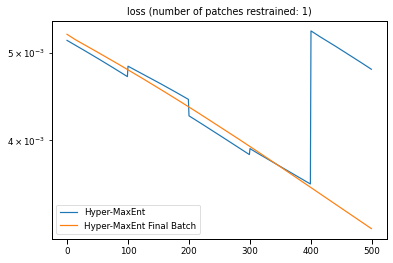

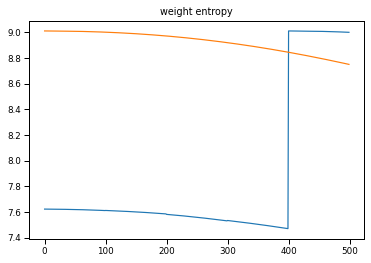

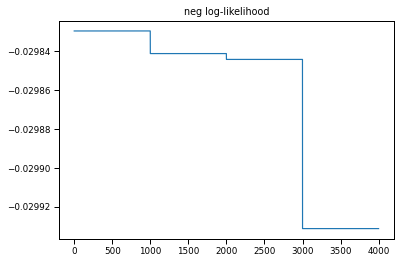

In [51]:
# plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

# plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

Text(0, 0.5, 'Population Fraction')

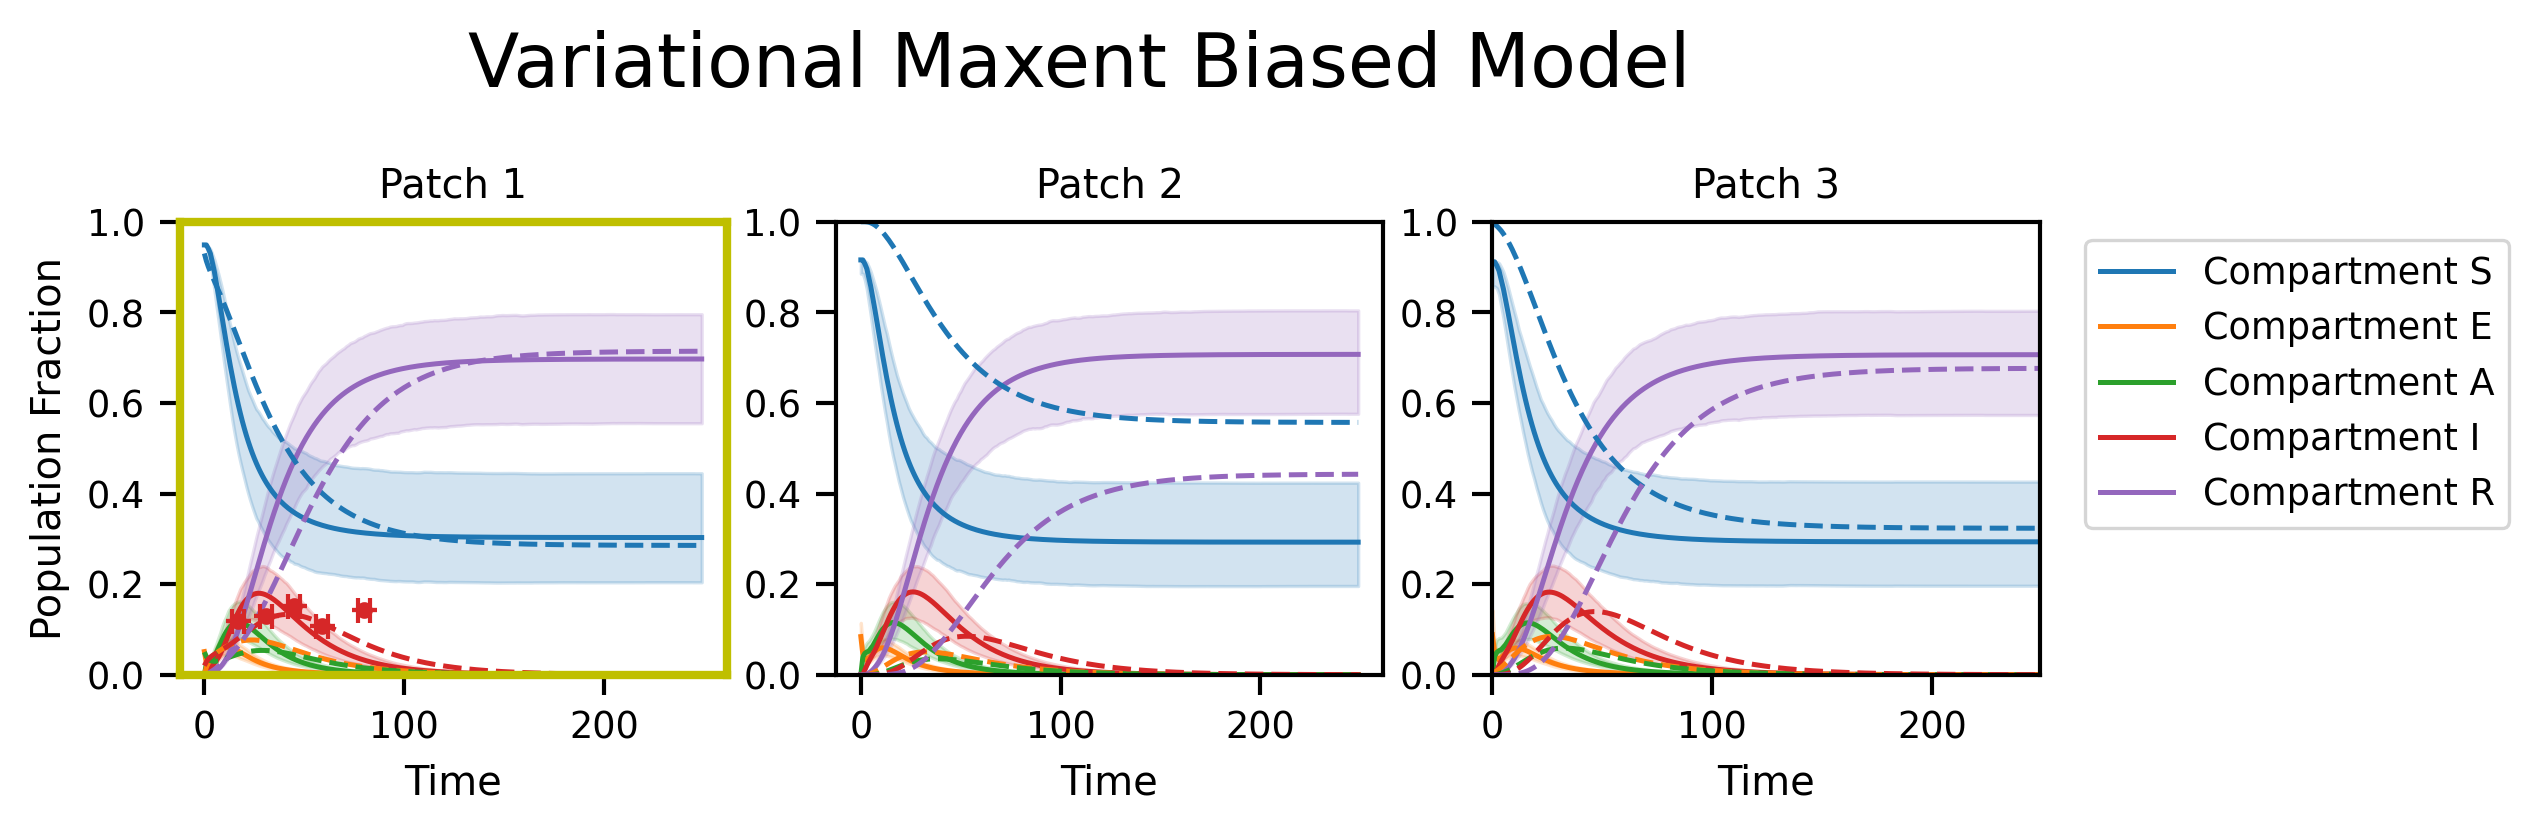

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Variational Maxent Biased Model', y = 1.2, fontsize = 18)
py0.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
py0.traj_quantile(hme_model.trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
py0.traj_quantile(hme_model.trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
# plt.savefig('varitional_maxent.svg', dpi=600)